In [1]:
import wandb
import numpy as np
import torch
from torch.utils.data import DataLoader
from scipy.linalg import sqrtm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from diff_ts import EpsilonTheta
from diff_ts import GaussianDiffusion
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Generate Datasets


In [26]:
run = wandb.init(project="test_train_2")
artifact = run.use_artifact('fyp_a/test_train_2/bs128_lr0.001_be0.8_ds50_ltl2_bschlinear:v0')
artifact_dir = artifact.download()
model = GaussianDiffusion(EpsilonTheta([256]), input_size=256, diff_steps=50)
model.load_state_dict(torch.load(f"{artifact_dir}/bs128_lr0.001_be0.8_ds50_ltl2_bschlinear.pth"))

model.eval()

num_signals = 1000
batch_size = 10  # You can adjust this batch size based on your system's capability
generated_signals = []

with torch.no_grad():
    while len(generated_signals) < num_signals:
        noise_shape = (batch_size, 1, 256)  # Define the noise shape for the batch
        random_noise = torch.randn(noise_shape, device=model.betas.device)
        batch_signals = model.p_sample_loop(random_noise)
        # Append the generated signals to the list and reshape them immediately
        generated_signals.extend(batch_signals.squeeze().cpu().detach().numpy())

# Convert list to NumPy array
generated_signals = np.array(generated_signals)
if generated_signals.shape[0] > num_signals:
    generated_signals = generated_signals[:num_signals]  # Trim extra signals if any

# The dataset should now be in the shape (1000, 256)
assert generated_signals.shape == (1000, 256), "Dataset shape is incorrect."

wandb:   1 of 1 files downloaded.  


In [34]:
model.eval()

GaussianDiffusion(
  (denoise_fn): EpsilonTheta(
    (input_projection): Conv1d(1, 8, kernel_size=(1,), stride=(1,), padding=(2,))
    (diffusion_embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=32, out_features=64, bias=True)
      (projection2): Linear(in_features=64, out_features=64, bias=True)
    )
    (residual_layers): ModuleList(
      (0-7): 8 x ResidualBlock(
        (dilated_conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (diffusion_projection): Linear(in_features=64, out_features=8, bias=True)
        (output_projection): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
      )
    )
    (skip_projection): Conv1d(8, 8, kernel_size=(3,), stride=(1,))
    (output_projection): Conv1d(8, 1, kernel_size=(3,), stride=(1,))
  )
)

In [27]:
file_path = 'C:/Users/Alexia/datasets/train_set.pth'
dataset = torch.load(file_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=None)

original_signals = []

# Iterate through your DataLoader
for i, data in enumerate(train_loader):
    signals = data['signals']  
    for signal in signals:
        # Flatten the signal and convert to numpy array
        flattened_signal = signal.squeeze().cpu().numpy()
        original_signals.append(flattened_signal)

# Convert list of numpy arrays to a single numpy array
real_signals = np.stack(original_signals)

sample_size = 1000
index = np.random.choice(real_signals.shape[0], sample_size, replace=False)  
# real_data_samples = real_data[index]
real_data_samples = real_signals[:sample_size]
real_data_samples.shape


(1000, 256)

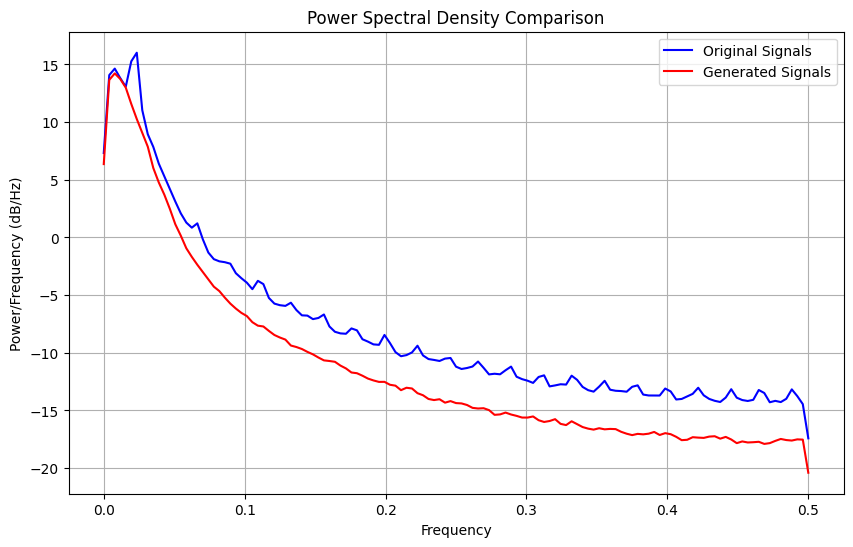

In [28]:
from scipy.signal import welch

def power_spectral_density(signals, fs=1.0):
 
    psds = []
    for signal in signals:
        freqs, psd = welch(signal, fs=fs, nperseg=len(signal))
        psds.append(psd)
    psds = np.array(psds)
    psd_mean = np.mean(psds, axis=0)
    return freqs, psd_mean


freqs_generated, psd_mean_generated = power_spectral_density(generated_signals)
freqs_real, psd_mean_real = power_spectral_density(real_data_samples)

plt.figure(figsize=(10, 6))
plt.plot(freqs_real, 10 * np.log10(psd_mean_real), label='Original Signals', color='blue')
plt.plot(freqs_generated, 10 * np.log10(psd_mean_generated), label='Generated Signals', color='red')
plt.title('Power Spectral Density Comparison')
plt.xlabel('Frequency')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()
#mean of 100 samples from orig and mean from training
#envolope of 100 samples maxmin as function of time max across time and minn across time
#boundry handling error
#weighting the loss function

PCA and t-sne


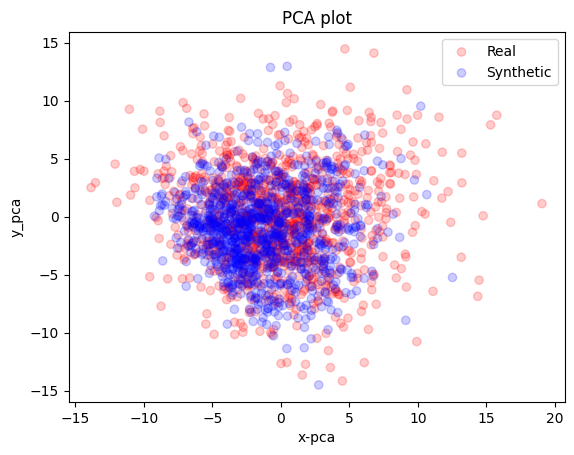

In [29]:
# PCA fitted on real data
# Parameters       

colors = ["red" for i in range(sample_size)] +  ["blue" for i in range(sample_size)]

# PCA Analysis
pca = PCA(n_components = 2)
pca.fit(real_data_samples)
pca_results = pca.transform(real_data_samples)
pca_hat_results = pca.transform(generated_signals)

# Plotting
f, ax = plt.subplots(1)

plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:sample_size], alpha = 0.2, label = "Real")
plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[sample_size:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('PCA plot')
plt.xlabel('x-pca')
plt.ylabel('y_pca')
plt.show()

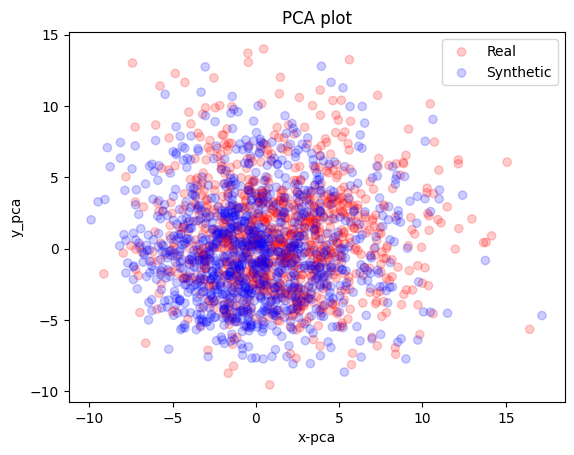

In [30]:
# PCA fitted on synthetic data
# Parameters        
colors = ["red" for i in range(sample_size)] +  ["blue" for i in range(sample_size)]

# PCA Analysis
pca = PCA(n_components = 2)
pca.fit(generated_signals)
pca_results = pca.transform(real_data_samples)
pca_hat_results = pca.transform(generated_signals)

# Plotting
f, ax = plt.subplots(1)

plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:sample_size], alpha = 0.2, label = "Real")
plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[sample_size:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('PCA plot')
plt.xlabel('x-pca')
plt.ylabel('y_pca')
plt.show()

In [31]:
# Do t-SNE Analysis together       
final_arrayX = np.concatenate((real_data_samples, generated_signals), axis = 0)
final_arrayX.shape

(2000, 256)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 4.388404
[t-SNE] KL divergence after 50 iterations with early exaggeration: 73.057808
[t-SNE] KL divergence after 300 iterations: 2.212630


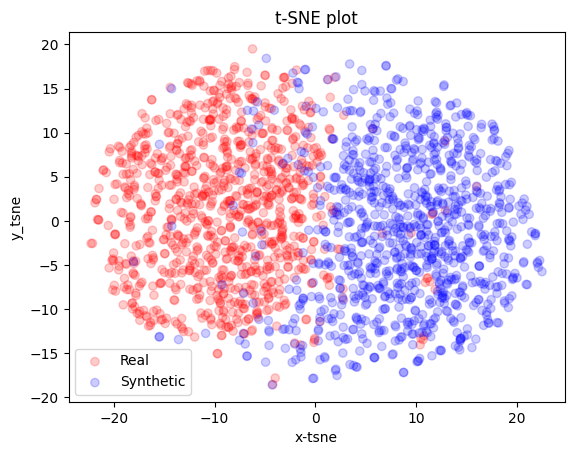

In [32]:
# TSNE anlaysis
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(final_arrayX)

# Plotting
f, ax = plt.subplots(1)

plt.scatter(tsne_results[:sample_size,0], tsne_results[:sample_size,1], c = colors[:sample_size], alpha = 0.2, label = "Real")
plt.scatter(tsne_results[sample_size:,0], tsne_results[sample_size:,1], c = colors[sample_size:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.show()

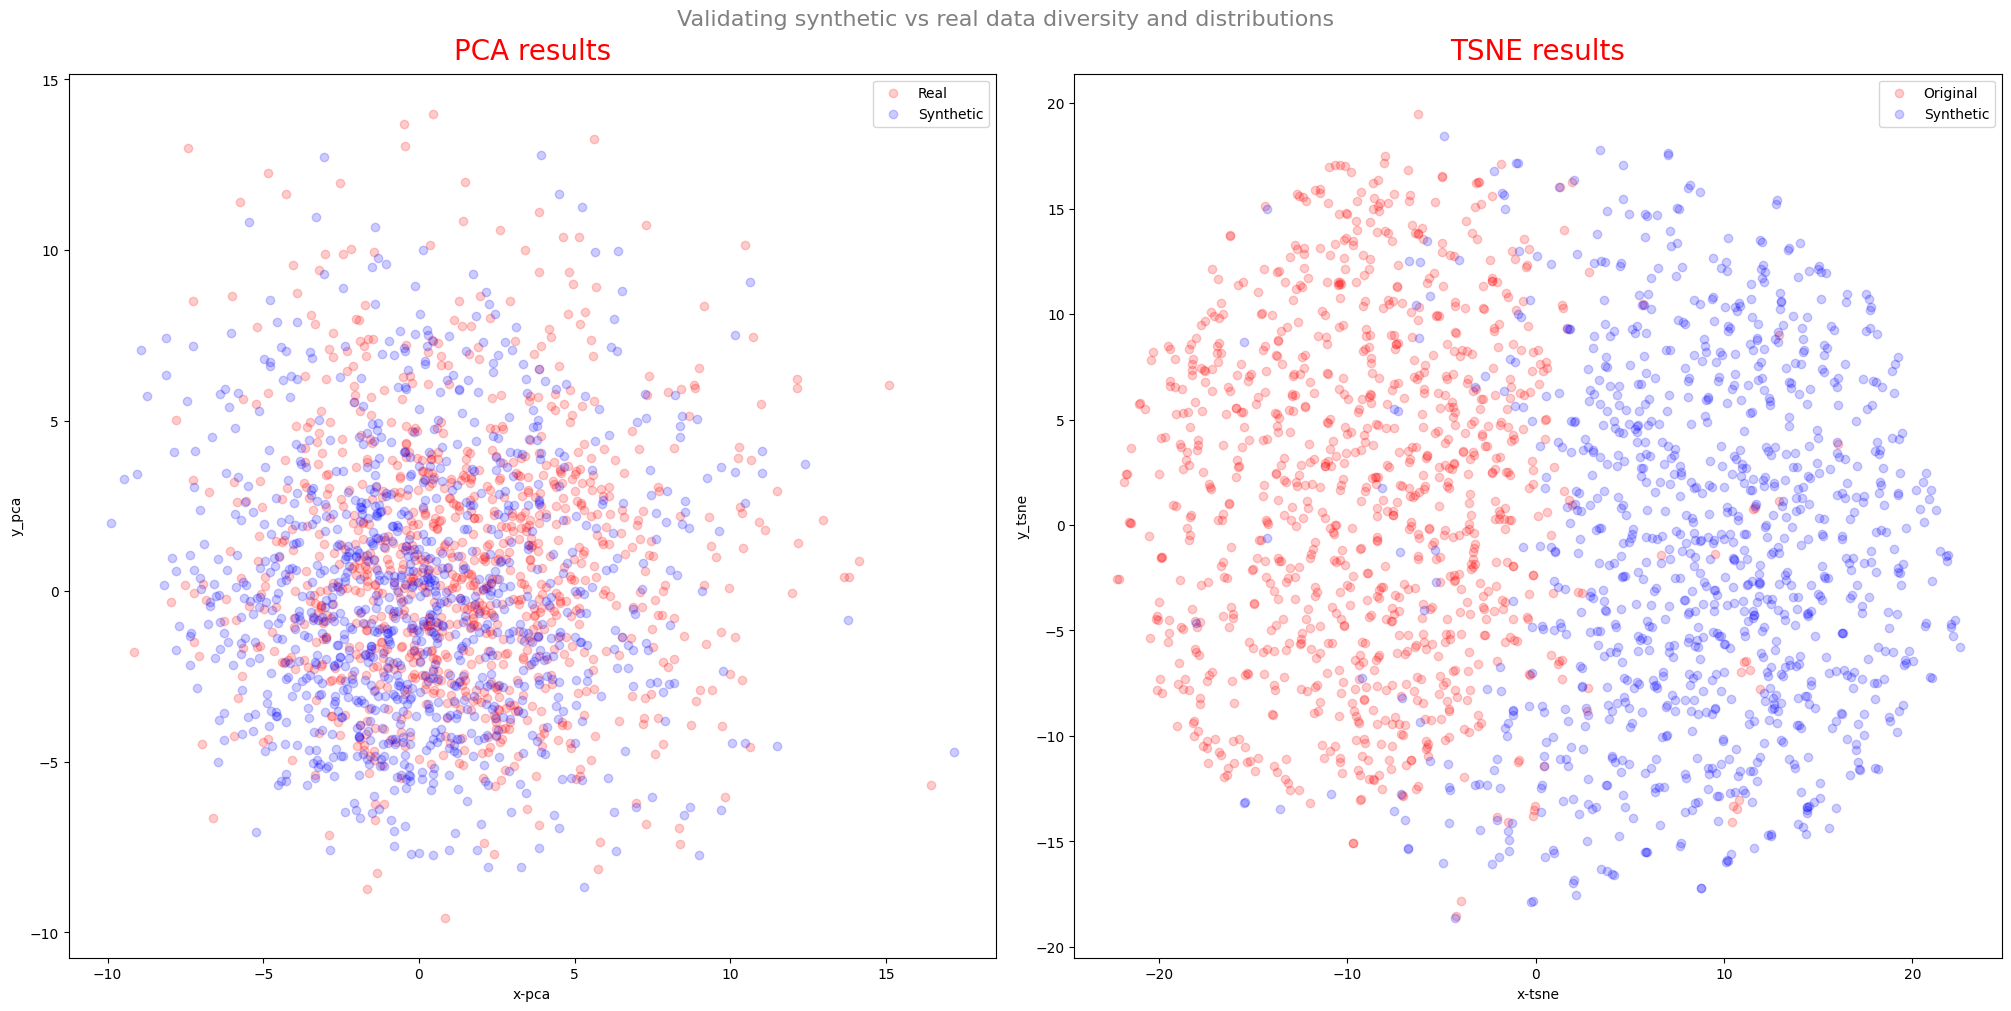

In [33]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_results[:, 0], pca_results[:,1],
            c='red', alpha=0.2, label='Real')
plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1],
            c='blue', alpha=0.2, label='Synthetic')
ax.legend()
ax.set_xlabel('x-pca')
ax.set_ylabel('y_pca')

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results[:sample_size, 0], tsne_results[:sample_size,1],
            c='red', alpha=0.2, label='Original')
plt.scatter(tsne_results[sample_size:,0], tsne_results[sample_size:,1],
            c='blue', alpha=0.2, label='Synthetic')

ax2.legend()
ax2.set_xlabel('x-tsne')
ax2.set_ylabel('y_tsne')

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey');